In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import ta

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from strategies.startegy001 import Strategy001
from strategies.strategy_bacd import StrategyBacd
from strategies.simple import SimpleStrategy
from strategies.strategy_macd_cci import StrategyMacdCci
from strategies.strategy_bacd_macd import StrategyBacdMacd
from strategies.strategy_waiting_game import StrategyWaiter
from strategies.strategy_longtime_low import StrategyLongtimeLow

ModuleNotFoundError: No module named 'strategies.startegy002'

In [2]:
SYMBOL = 'ETH'
from_csv = pd.read_csv(f'../../data/{SYMBOL}.csv')
df = from_csv.set_index(pd.DatetimeIndex(from_csv['begins_at'].values))
df = df.rename(columns={"begins_at":"time", "open_price":"open", "close_price":"close", "low_price":"low", "high_price":"high"})
df['price'] = df[['high','low']].mean(axis=1)
df = df.drop(columns=["time"])

In [3]:
#Create a function to signal when to buy and sell an asset
def calculate_when_to_trade(dataframe, strategy):
    sigPriceBuy = []
    sigPriceSell = []
    cycles = []
    bought = (False, 0, 0)
    for time, row in dataframe.iterrows():
        current_price = row['price']
        if (not bought[0]) and strategy.shouldBuy(dataframe, time):
            sigPriceBuy.append(current_price)
            sigPriceSell.append(np.nan)
            bought = (True, current_price, time)
        elif bought[0] and strategy.shouldSell(dataframe, current_price, bought[1], time, bought[2]): 
            sigPriceSell.append(current_price)
            sigPriceBuy.append(np.nan)
            cycles.append(current_price - dataframe.loc[bought[2]]['price'] - 2)
            # print(f"Profit: {current_price - dataframe['average'][bought]}")
            bought = (False, 0, 0)
        else: #Handling nan values
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
    return (sigPriceBuy, sigPriceSell, cycles)

def plot(df, sigPriceBuy, sigPriceSell):
    plt.figure(figsize=(20,4.5))
    plt.xticks(rotation=45)
    plt.plot( df['price'],  label='price', linewidth=1, zorder=1)
    plt.scatter(df.index, sigPriceBuy, color = 'green', label='Buy Signal', marker = '^', alpha = 1, s=10, zorder=2)
    plt.scatter(df.index, sigPriceSell, color = 'red', label='Sell Signal', marker = 'v', alpha = 1, s=10, zorder=3)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

Executed buy and sell strategies:
Number of cycles: 14
Total: $235.00
Avg profit/cycle: $16.79
Profit per 15sec: 0.003455271635887786


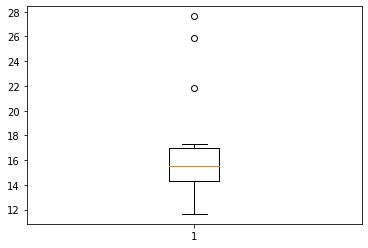

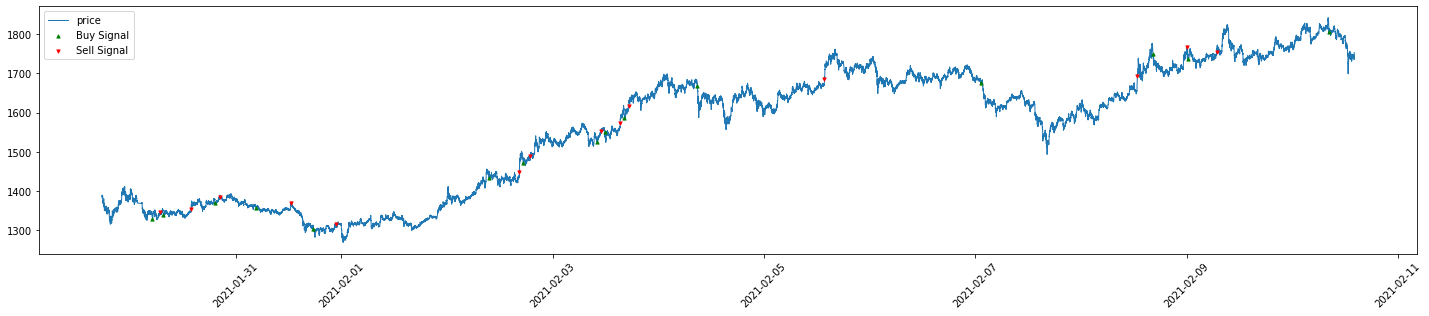

In [4]:
# strat = Strategy002()
# strat = StrategyBacd()
# strat = Strategy001()
# strat = SimpleStrategy()
# strat = StrategyMacdCci()
# strat = StrategyBacdMacd()
# strat = StrategyWaiter()
strat = StrategyLongtimeLow()

df = strat.generateIndicators(df)

sigPriceBuy, sigPriceSell, cycles = calculate_when_to_trade(df, strat)

print("Executed buy and sell strategies:")
print(f"Number of cycles: {len(cycles)}")
print(f"Total: ${sum(cycles):.2f}")
if len(cycles):
    print(f"Avg profit/cycle: ${sum(cycles)/len(cycles):.2f}")
print(f"Profit per 15sec: {sum(cycles)/len(df)}")

plt.boxplot(cycles)
plt.show()
plot(df, sigPriceBuy, sigPriceSell)